# Self-training for ASR with HuggingFace

Performance of atomatic speech recognition (ASR) models had increased substantially during last years. Unfortunatly the performance on low resource languages might still be mediocre.
To improve the performance in low data regime self-training is often employed. Noizy-student[ref] is popular self-training method. Iterative pseudo-labeling is particularly well suited for ASR. One can fuse audio model with language model to improve the speech recognition performance. Language model not only provides a mean to improve quality of pseudo-labels but also the LM fusion scores can be used to filter pseudo labeled data to select most confident samples. In this notebook I employ simple heuristic for filtering the data introduced in [Improved Noisy Student Training for Automatic Speech Recognition](https://arxiv.org/abs/2005.09629).

I'm using [pyctcdecode] - integrating LM to ASR system. For detailed introduction to training KenLM and using it with HuggingFace refer to [this  exelent blogpost](https://huggingface.co/blog/wav2vec2-with-ngram).

In [ ]:
# !pip install git+https://github.com/arampacha/transformers.git@wav2vec2-with-lm-decode-score

In [1]:
import os
import glob

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm.auto import tqdm

from transformers import (
    Wav2Vec2ProcessorWithLM, 
    Wav2Vec2Processor, 
    Wav2Vec2FeatureExtractor,
    Wav2Vec2CTCTokenizer,
    Wav2Vec2ForCTC,
    Trainer,
    TrainingArguments,
)

from datasets import load_dataset, load_metric, Audio

import bitsandbytes as bnb

In [2]:
import wandb

%env WANDB_ENTITY = arampacha
wandb_entity = os.environ["WANDB_ENTITY"]

%env WANDB_PROJECT = xlsr-hy
wandb_project = os.environ["WANDB_PROJECT"]

%env WANDB_LOG_MODEL = false
%env WANDB_WATCH = false

env: WANDB_ENTITY=arampacha
env: WANDB_PROJECT=xlsr-hy
env: WANDB_LOG_MODEL=false
env: WANDB_WATCH=false


In [3]:
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            return_tensors="pt",
        )
        
        if "labels" in features[0].keys():
            label_features = [{"input_ids": feature["labels"]} for feature in features]
            with self.processor.as_target_processor():
                labels_batch = self.processor.pad(
                    label_features,
                    padding=self.padding,
                    return_tensors="pt",
                )

            # replace padding with -100 to ignore loss correctly
            labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

            batch["labels"] = labels

        return batch

## Scores for filtering

The first we need a model trained on labeled data. Common Voice dataset has 738 training samples for Armenian and I haven't found any additional labeled data publically available.
The model pretrained on Common Voice is available [here](). It achieves 22.6 word error rate (WER) with LM boosted decoding.

Notice that large ASR models like those of Wav2Vec2-XLS-R family can learn grammar in some extent. At some point during training the model can start to overfit to train set vocab. The valid loss stops decreasing while validation WER still improves. In my experience validation loss is better indicator of performance after LM fusion.

In [14]:
model_dir = "wav2vec2-xls-r-300m-hy-ns"
lang_id = "hy-AM"

repo_name = "wav2vec2-xls-r-300m-hy-ns"

In [5]:
@torch.no_grad()
def predict(model, dataset, bs=32, device="cpu"):
    model.eval()
    model.to(device)
    loader = DataLoader(
        dataset, batch_size=bs, collate_fn=data_collator, shuffle=False, drop_last=False, num_workers=4
    )
    all_logits = []
    for batch in tqdm(loader):
        batch = {k:v.to(device) for k,v in batch.items()}
        logits = model(**batch).logits.cpu()
        all_logits.append(logits)
    lens = [logits.shape[1] for logits in all_logits]
    max_len = max(lens)
    all_logits = [F.pad(logits, (0, 0, 0, max_len-l), value=-100.) for logits, l in zip(all_logits, lens)]
    return torch.cat(all_logits)

In [6]:
common_voice_train = load_dataset("mozilla-foundation/common_voice_8_0", lang_id, split="train+validation", use_auth_token=True)
common_voice_test = load_dataset("mozilla-foundation/common_voice_8_0", lang_id, split="test", use_auth_token=True)
common_voice_train = common_voice_train.remove_columns(["accent", "age", "gender", "client_id", "down_votes", "locale", "segment", "up_votes"])
common_voice_test = common_voice_test.remove_columns(["accent", "age", "gender", "client_id", "down_votes", "locale", "segment", "up_votes"])
common_voice_train = common_voice_train.cast_column("audio", Audio(sampling_rate=16_000))
common_voice_test = common_voice_test.cast_column("audio", Audio(sampling_rate=16_000))
print(len(common_voice_train), len(common_voice_test))

Reusing dataset common_voice (/workspace/cache/hf/datasets/mozilla-foundation___common_voice/hy-AM/8.0.0/b8bc4d453193c06a43269b46cd87f075c70f152ac963b7f28f7a2760c45ec3e8)
Reusing dataset common_voice (/workspace/cache/hf/datasets/mozilla-foundation___common_voice/hy-AM/8.0.0/b8bc4d453193c06a43269b46cd87f075c70f152ac963b7f28f7a2760c45ec3e8)


728 335


In [7]:
def extract_all_chars(batch):
    all_text = " ".join(batch["sentence"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}

In [8]:
import re
chars_to_remove_regex = '[\,\?\.\!\-\;\:\"\“\%\‘\”\�\'«»\(\)։՝՞՛՚]'

def normalize_text(batch):
    text = batch["sentence"]
    text = re.sub(chars_to_remove_regex, '', text.lower())+" "
    return {"sentence":text}

In [9]:
common_voice_train = common_voice_train.map(normalize_text)
common_voice_test = common_voice_test.map(normalize_text)

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

In [10]:
test_transcripts = common_voice_test["sentence"]
test_transcripts[:5]

['վատիկանի թանգարանները համարվում են աշխարհում ամենամեծ թանգարաններից մեկը ',
 'լոյանը չինական հնագույն բնակավայրերից է ',
 'կան նաև սանրեր կենդանիների բրդի համար ',
 'այդպես կայացել է նրանց ծանոթությունը ',
 'որոշումը ենթարկվել է քննադատության ']

In [11]:
vocab_train = common_voice_train.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=common_voice_train.column_names)
vocab_test = common_voice_test.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=common_voice_test.column_names)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [12]:
all_chars_train = sorted(vocab_train["vocab"][0])
all_chars_test = sorted(vocab_test["vocab"][0])
print("".join(all_chars_train))
print("".join(all_chars_test))

 աբգդեզէըթժիլխծկհձղճմյնշոչպջռսվտրցւփքօֆև
 աբգդեզէըթժիլխծկհձղճմյնշոչպջռսվտրցւփքօֆև


In [13]:
vocab_dict = {v: k for k, v in enumerate(sorted(vocab_train["vocab"][0]))}
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]
vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
len(vocab_dict)

42

In [15]:
if not os.path.isfile(f"{model_dir}/vocab.json"):
    import json
    with open(f"{model_dir}/vocab.json", "w") as f:
        json.dump(vocab_dict, f)

In [16]:
tokenizer = Wav2Vec2CTCTokenizer.from_pretrained(model_dir, unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")
feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=True)
processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

file wav2vec2-xls-r-300m-hy-ns/config.json not found
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [17]:
def prepare_dataset(batch):
    audio = batch["audio"]

    # batched output is "un-batched"
    batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
    batch["length"] = len(batch["input_values"])
    
    with processor.as_target_processor():
        batch["labels"] = processor(batch["sentence"]).input_ids
    return batch

In [18]:
common_voice_train = common_voice_train.map(prepare_dataset, remove_columns=common_voice_test.column_names)
common_voice_test = common_voice_test.map(prepare_dataset, remove_columns=common_voice_test.column_names)

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

In [19]:
wer_metric = load_metric("wer")
cer_metric = load_metric("cer")

def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)
    cer = cer_metric.compute(predictions=pred_str, references=label_str)
    return {"wer": wer, "cer":cer}

In [20]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

In [21]:
model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-xls-r-300m", 
    attention_dropout=0.0,
    hidden_dropout=0.1,
    feat_proj_dropout=0.0,
    mask_time_prob=0.75,
    mask_feature_prob=0.25,
    mask_feature_length=64,
    layerdrop=0.05,
    ctc_loss_reduction="mean", 
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size=len(processor.tokenizer),
)
model.freeze_feature_encoder();

Some weights of the model checkpoint at facebook/wav2vec2-xls-r-300m were not used when initializing Wav2Vec2ForCTC: ['project_q.weight', 'quantizer.weight_proj.bias', 'project_q.bias', 'quantizer.codevectors', 'project_hid.weight', 'project_hid.bias', 'quantizer.weight_proj.weight']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-xls-r-300m and are newly initialized: ['lm_head.weight', 'lm_head.bias']
You should probably TRAIN this model on a down-stream task to be able to use it 

In [22]:
from torch.optim.lr_scheduler import LambdaLR

def get_tri_stage_schedule(
    optimizer, num_training_steps, ratios=[0.1, 0.4, 0.5], num_warmup_steps=None, num_hold_steps=None, start_ratio=0.01, end_ratio=0.05 
):
    assert (num_warmup_steps is None) == (num_hold_steps is None)
    if num_warmup_steps is None:
        num_warmup_steps = int(ratios[0]*num_training_steps)
        num_hold_steps = int(ratios[1]*num_training_steps)
        start_decay_step = num_warmup_steps + num_hold_steps
        a_w, b_w = (1-start_ratio)/num_warmup_steps, start_ratio
        num_decay_steps = num_training_steps - start_decay_step
        a_d, b_d = (end_ratio-1)/num_decay_steps, 1.
        
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return a_w * float(current_step) + b_w
        if current_step < start_decay_step:
            return 1.
        return max(end_ratio, a_d * float(current_step - start_decay_step) + b_d )
    
    return LambdaLR(optimizer, lr_lambda)

In [23]:
num_training_steps = 1600

In [24]:
optimizer = bnb.optim.AdamW8bit(model.parameters(), lr=8e-5, betas=(0.9, 0.98), eps=1e-8, weight_decay=0.)

scheduler = get_tri_stage_schedule(optimizer, num_training_steps)

In [25]:
training_args = TrainingArguments(
    output_dir=model_dir,
    group_by_length=True,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=4,
    dataloader_num_workers=8,
    evaluation_strategy="steps",
    max_steps=num_training_steps,
    gradient_checkpointing=True,
    fp16=True,
    save_steps=200,
    eval_steps=200,
    logging_steps=200,
    learning_rate=8e-5,
    save_total_limit=4,
    push_to_hub=False,
    run_name="xlsr-300m-hy-demo-1",
    report_to="wandb",
    load_best_model_at_end=True,
)

In [26]:
trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=common_voice_train,
    eval_dataset=common_voice_test,
    tokenizer=processor.feature_extractor,
    optimizers=(optimizer, scheduler)
)

max_steps is given, it will override any value given in num_train_epochs
Using amp half precision backend


### Training

In [27]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: length.
***** Running training *****
  Num examples = 728
  Num Epochs = 320
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 1600
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: Currently logged in as: arampacha (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Step,Training Loss,Validation Loss,Wer,Cer
200,7.868500,3.194159,1.000000,1.000000
400,3.544700,2.603772,1.000000,0.974001
600,2.442200,0.868212,0.820453,0.214062
800,1.605500,0.610635,0.697112,0.158928
1000,1.327300,0.550194,0.654957,0.143247
1200,1.204300,0.556630,0.623341,0.135508
1400,1.109700,0.552339,0.606557,0.133434
1600,1.067400,0.545073,0.597580,0.130653


The following columns in the evaluation set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: length.
***** Running Evaluation *****
  Num examples = 335
  Batch size = 32
Saving model checkpoint to wav2vec2-xls-r-300m-hy-ns/checkpoint-200
Configuration saved in wav2vec2-xls-r-300m-hy-ns/checkpoint-200/config.json
Model weights saved in wav2vec2-xls-r-300m-hy-ns/checkpoint-200/pytorch_model.bin
Configuration saved in wav2vec2-xls-r-300m-hy-ns/checkpoint-200/preprocessor_config.json
The following columns in the evaluation set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: length.
***** Running Evaluation *****
  Num examples = 335
  Batch size = 32
Saving model checkpoint to wav2vec2-xls-r-300m-hy-ns/checkpoint-400
Configuration saved in wav2vec2-xls-r-300m-hy-ns/checkpoint-400/config.json
Model weights saved in wav2vec2-xls-r-300m-hy-ns/checkpoint-400/pytorch_model.bin
Configuration saved in wav2vec2-xls-r-3

TrainOutput(global_step=1600, training_loss=2.521186532974243, metrics={'train_runtime': 8754.7736, 'train_samples_per_second': 23.393, 'train_steps_per_second': 0.183, 'total_flos': 5.069586580567806e+19, 'train_loss': 2.521186532974243, 'epoch': 319.87})

In [28]:
trainer.save_model()

Saving model checkpoint to wav2vec2-xls-r-300m-hy-ns
Configuration saved in wav2vec2-xls-r-300m-hy-ns/config.json
Model weights saved in wav2vec2-xls-r-300m-hy-ns/pytorch_model.bin
Configuration saved in wav2vec2-xls-r-300m-hy-ns/preprocessor_config.json


In [34]:
wandb.finish()

eval/cer,██▂▁▁▁▁▁
eval/loss,█▆▂▁▁▁▁▁
eval/runtime,▄▂▄▇▃▇█▁
eval/samples_per_second,▅▇▅▂▆▂▁█
eval/steps_per_second,▅▇▅▂▆▂▁█
eval/wer,██▅▃▂▁▁▁
train/epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇███
train/global_step,▁▁▂▂▃▃▄▄▅▅▆▆▇▇███
train/learning_rate,████▆▅▃▁
train/loss,█▄▂▂▁▁▁▁
train/total_flos,▁


In [29]:
preds = trainer.predict(common_voice_test)
logits = preds.predictions

The following columns in the test set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: length.
***** Running Prediction *****
  Num examples = 335
  Batch size = 32


In [30]:
processor_lm = Wav2Vec2ProcessorWithLM.from_pretrained("/workspace/output/hy/models/wav2vec2-xls-r-1b-hy/")

loading feature extractor configuration file /workspace/output/hy/models/wav2vec2-xls-r-1b-hy/preprocessor_config.json
Feature extractor Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padding_value": 0,
  "processor_class": "Wav2Vec2ProcessorWithLM",
  "return_attention_mask": true,
  "sampling_rate": 16000
}

Didn't find file /workspace/output/hy/models/wav2vec2-xls-r-1b-hy/tokenizer.json. We won't load it.
loading file /workspace/output/hy/models/wav2vec2-xls-r-1b-hy/vocab.json
loading file /workspace/output/hy/models/wav2vec2-xls-r-1b-hy/tokenizer_config.json
loading file /workspace/output/hy/models/wav2vec2-xls-r-1b-hy/added_tokens.json
loading file /workspace/output/hy/models/wav2vec2-xls-r-1b-hy/special_tokens_map.json
loading file None
Adding <s> to the vocabulary
Adding </s> to the vocabulary


In [31]:
logits.shape

(335, 492, 44)

In [33]:
lm_params = {"alpha":0.5, "beta":1.5}
best_wer = 1.

print(f"alpha\t| beta\t| wer\t\t| cer")
for alpha in [0.5, 0.6, 0.7]:
    for beta in [1.5, 2., 2.5, 3.,]:
        processor_lm.decoder.reset_params(alpha=alpha, beta=beta)
        decoded_preds = processor_lm.batch_decode(logits, beam_width=100, num_processes=8)
        wer = wer_metric.compute(predictions=decoded_preds.text, references=test_transcripts)
        cer = cer_metric.compute(predictions=decoded_preds.text, references=test_transcripts)
        if wer < best_wer:
            lm_params["alpha"] = alpha
            lm_params["beta"] = beta
            best_wer = wer
        print(f"{alpha}\t| {beta}\t| {wer:.4f}\t| {cer:.4f}")
        
print("\nBest LM parameters: ", lm_params)

alpha	| beta	| wer		| cer
0.5	| 1.5	| 0.2920	| 0.0711
0.5	| 2.0	| 0.2923	| 0.0712
0.5	| 2.5	| 0.2939	| 0.0716
0.5	| 3.0	| 0.2966	| 0.0715
0.6	| 1.5	| 0.2873	| 0.0720
0.6	| 2.0	| 0.2884	| 0.0712
0.6	| 2.5	| 0.2881	| 0.0706
0.6	| 3.0	| 0.2916	| 0.0708
0.7	| 1.5	| 0.2877	| 0.0732
0.7	| 2.0	| 0.2842	| 0.0723
0.7	| 2.5	| 0.2845	| 0.0719
0.7	| 3.0	| 0.2842	| 0.0714

Best LM parameters:  {'alpha': 0.7, 'beta': 2.0}


In [35]:
processor_lm.decoder.reset_params(**lm_params)
decoded_preds = processor_lm.batch_decode(logits, beam_width=100, num_processes=8)

In [36]:
import random

ids = random.sample(range(len(common_voice_test)), k=5)
for i in ids:
    print(decoded_preds.logit_score[i], decoded_preds.lm_score[i])
    print(decoded_preds.text[i])
    print(test_transcripts[i])

-15.00629891494811 -36.10539751911238
վերջին անգամ բազմաթիվ ձեռագրեր ոչնչացան առաջին համաշխարհային պատերազմի տարիներին
վերջին անգամ բազմաթիվ ձեռագրեր ոչնչացան առաջին համաշխարհային պատերազմի տարիներին 
-18.88247006201864 -21.816377967257626
մտքի ճկունությունը ստեղծագործական ընդունակությունների առկայության դրսևորումներից մեկն է
մտքի ճկունությունը ստեղծագործական ընդունակությունների առկայության դրսևորումներից մեկն է 
-20.694962102139808 -71.93717848657455
գելը իր ստեղծած կերպարի նանվանում է չարաճճի օպերային դենդի
քուեյլը իր ստեղծած կերպարին անվանում է չարաճճի օպերային դենդի 
-21.81080996648263 -34.990664297362855
քննարկենք ինչու է ճիշտ վերջին հատկությունը
քննարկենք թե ինչու է ճիշտ վերջին հատկությունը 
-15.957373845367895 -72.43214053572748
ժողովրդական դպրոց նավարդելուցհետու աշխատել է բրանդենբուրգյան հացի խանութում
ժողովրդական դպրոցն ավարտելուց հետո աշխատել է բրանդերբուրգյան հացի խանութում 


`pyctcdecode` does beam search for decoding. Candidate sequences are selected by the negative log likelihood. Total score is composed of NLL assigned to token sequence by the model and NLL score from language model.
Negative log likelihood of sequence is a sum of NLLs of individual elements. Therefore the score returned by decoder is not suited well for filtering the generated labels: longer sequences are expected to have lower score. To adjust the scores for filtering I'm adopting an approach from [Improved Noisy Student Training for Automatic Speech Recognition](https://arxiv.org/abs/2005.09629).
$$ (s_{LM} - \alpha*l - \beta)/ (\sigma \sqrt l) $$

In [37]:
text_length = np.array([len(s) for s in decoded_preds.text])
lm_scores = np.array(decoded_preds.lm_score)

In [38]:
wer_metric.compute(predictions=decoded_preds.text, references=test_transcripts)

0.28415300546448086

In [39]:
cer_metric.compute(predictions=decoded_preds.text, references=test_transcripts)

0.07228123419322205

In [40]:
example_wer = np.array([wer_metric.compute(predictions=[pred], references=[ref]) for pred, ref in zip(decoded_preds.text, test_transcripts)])
example_wer.mean()

0.28854536839611467

It's easy to fit a line to the data. For instance one can `scikit-learn` library for this purpose.

In [41]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(np.expand_dims(np.array(text_length), axis=1), np.array(decoded_preds.lm_score))

a = reg.coef_[0]
b = reg.intercept_
print(f"{a:.7f}, {b:.7f}")

-0.6229814, -18.6591776


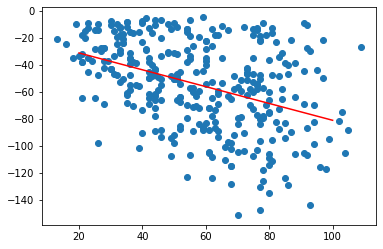

In [42]:
fig, ax = plt.subplots()
ax.scatter(text_length, decoded_preds.lm_score)
x = np.array([20, 100])
ax.plot(x, a*x+b, "r")
plt.show()

In [43]:
scores = (lm_scores - a*text_length - b)/ np.sqrt(text_length)
std = scores.std()
print(std)

3.8947836733862813


In [44]:
scores  = scores/ scores.std()

Finally we can check how the filtering reflects on the label quality.

In [45]:
mask = scores > .5

print(f"Selected {mask.sum()}/{len(mask)} examples after filtering with average WER {example_wer[mask].mean():.5f}")

Selected 114/335 examples after filtering with average WER 0.06044


## Pseudo-labeling

For dataset generation I'm using [VoxLingua107](http://bark.phon.ioc.ee/voxlingua107/) dataset. 

In [46]:
unsup_dataset = load_dataset("/workspace/data/scripts/voxlingua107.py", lang_id.split("-")[0], split="train")
len(unsup_dataset)

Reusing dataset vox_lingua107 (/workspace/cache/hf/datasets/vox_lingua107/hy/0.0.0/92f9b48de9b7250925c8d895423b1e5e809f341da44e36e62b481c87fe6a1ca4)


24868

In [47]:
from datasets import load_dataset, Dataset, Audio, load_from_disk

In [48]:
sampling_rate = 16_000
unsup_dataset = unsup_dataset.cast_column("audio", Audio(sampling_rate))

In [49]:
unsup_dataset[0]

{'path': '/workspace/cache/hf/datasets/downloads/extracted/e2c69883717bc530ea985b078278eca672e297147dc25dbe8b1c2e751186f304/hy/PtZMJZrea3w__U__S1---0292.510-0301.900.wav',
 'audio': {'path': '/workspace/cache/hf/datasets/downloads/extracted/e2c69883717bc530ea985b078278eca672e297147dc25dbe8b1c2e751186f304/hy/PtZMJZrea3w__U__S1---0292.510-0301.900.wav',
  'array': array([-0.00149536, -0.00271606, -0.00183105, ..., -0.00839233,
         -0.0062561 , -0.00439453]),
  'sampling_rate': 16000}}

In [50]:
unsup_dataset = unsup_dataset.map(lambda s: {"duration": len(s["audio"]["array"]) / sampling_rate})

Loading cached processed dataset at /workspace/cache/hf/datasets/vox_lingua107/hy/0.0.0/92f9b48de9b7250925c8d895423b1e5e809f341da44e36e62b481c87fe6a1ca4/cache-7e876b6e58276cea.arrow


In [51]:
durs = np.array(unsup_dataset["duration"])

durs.mean(), durs.std(), durs.min(), durs.max()

(9.97123931106241, 4.763985759128929, 1.89, 20.0)

In [52]:
filtered_dataset = unsup_dataset.filter(lambda x: (3. < x < 16.), input_columns="duration")
len(filtered_dataset)

Loading cached processed dataset at /workspace/cache/hf/datasets/vox_lingua107/hy/0.0.0/92f9b48de9b7250925c8d895423b1e5e809f341da44e36e62b481c87fe6a1ca4/cache-96f89da5fecedc13.arrow


20694

In [53]:
filtered_dataset = filtered_dataset.sort("duration")

Loading cached sorted indices for dataset at /workspace/cache/hf/datasets/vox_lingua107/hy/0.0.0/92f9b48de9b7250925c8d895423b1e5e809f341da44e36e62b481c87fe6a1ca4/cache-b68a45dfe0d0dc6e.arrow


In [54]:
durs = np.array(filtered_dataset["duration"])

durs.mean(), durs.std(), durs.min(), durs.max()

(8.68453510377404, 3.5985018135481797, 3.01, 15.99)

In [55]:
def preprocess(batch):
    audio = batch["audio"]
    
    batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
    # batch["length"] = len(batch["input_values"])
    return batch

In [56]:
processed_dataset = filtered_dataset.map(preprocess, remove_columns=filtered_dataset.column_names, num_proc=5)

## VoxLingua inference

In [57]:
# vl_logits = predict(model, processed_dataset, device="cuda", bs=32).numpy()

In [58]:
vl_logits = trainer.predict(processed_dataset).predictions
vl_logits.shape

***** Running Prediction *****
  Num examples = 20694
  Batch size = 32


(20694, 799, 44)

In [59]:
np.save("voxlingua_hy_logits_1.npy", vl_logits)

In [60]:
vl_decoded_preds = processor_lm.batch_decode(vl_logits, beam_width=100, num_processes=8)

In [61]:
vl_decoded_preds.text[:10]

['ճանապարհի կեսն է',
 'շամե գնում էին երևան',
 'ինչ վերաբերվում է ամքոր միջազգային կազմակերպությանը',
 'հիմնականում մայսները գնում են սիլիկոնյան հովիտ',
 'տարածման ժամանակակից ու արդյունավետ այտերը',
 'ինչու նաև',
 'ռոպէր քոչարյանի փաստաբանների ընտրած մարտավարության',
 'հաննագրիքորյան և րգմանուկյանաշոցարքսիան այսօր',
 'տաշել ասի գէախալում',
 'այլապես այս քամբեք իրականություն չէր դառնա']

In [62]:
vl_decoded_preds.lm_score[:10]

[-12.35923369838104,
 -30.3769261717412,
 -26.37022658856078,
 -51.1881242531656,
 -42.20113835486087,
 -7.537985312772793,
 -43.072356623004666,
 -68.51194965704599,
 -63.09046945295047,
 -38.81879677106827]

In [63]:
text_length = np.array([len(s) for s in vl_decoded_preds.text])
lm_scores = np.array(vl_decoded_preds.lm_score)

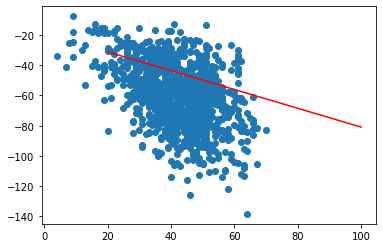

In [64]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(text_length[:1000], lm_scores[:1000])
x = np.array([20, 100])
ax.plot(x, a*x+b, "r")

In [65]:
vl_scores = (lm_scores - a*text_length - b)/ np.sqrt(text_length) / std

In [70]:
mask = vl_scores > .4

print(f"Selected {mask.sum()}/{len(mask)} examples after filtering")

Selected 553/20694 examples after filtering


In [71]:
len(common_voice_train)

728

In [72]:
idx = np.arange(len(mask))[mask]
print("lm_score\t|adj_score\t| text")
print("-"*100)
for i, _ in zip(idx, range(10)):
    
    print(f"{lm_scores[i]:.2f}\t\t|{vl_scores[i]:.2f}\t\t|", vl_decoded_preds.text[i])

lm_score	|adj_score	| text
----------------------------------------------------------------------------------------------------
-12.36		|1.04		| ճանապարհի կեսն է
-26.37		|0.87		| ինչ վերաբերվում է ամքոր միջազգային կազմակերպությանը
-7.54		|1.43		| ինչու նաև
-29.84		|0.54		| տարածաշրջանում իրավիճակը խիստ անհանգիստ
-36.64		|0.46		| պատմության ընթացքում հայաստանցի գործարարները ճրագ
-23.88		|0.69		| մեր առաջարկն է բոլոր ներդրողներին
-38.15		|0.40		| հուզմունքի արտահայտությունները կամ հազվադեպ բառեր
-36.44		|0.57		| ով օրինական ճանապարով վերադառնալ ռուսաստանի դաշնություն
-32.75		|0.64		| մասին է որը հայաստանի միջազգային պարտավորությունն և
-24.39		|0.71		| հատկապես մտահոգիչ են արտագաղթի թվերը


In [73]:
labeled_dataset = filtered_dataset.select(idx)

In [74]:
paths = labeled_dataset["path"]

In [75]:
from datasets import Dataset, DatasetDict

labeled_dataset = Dataset.from_dict({"path":paths, "audio":paths, "sentence":[vl_decoded_preds.text[i] for i in idx]})

In [76]:
labeled_dataset = labeled_dataset.cast_column("audio", Audio(sampling_rate))

In [77]:
labeled_dataset.save_to_disk("/workspace/data/hy/vox_lingua_hy_labeled_1")

In [78]:
from datasets import interleave_datasets, concatenate_datasets, DatasetDict, load_from_disk

In [79]:
len(labeled_dataset)

553

In [80]:
common_voice_train = load_dataset("mozilla-foundation/common_voice_8_0", lang_id, split="train+validation", use_auth_token=True)
common_voice_test = load_dataset("mozilla-foundation/common_voice_8_0", lang_id, split="test", use_auth_token=True)
common_voice_train = common_voice_train.remove_columns(["accent", "age", "gender", "client_id", "down_votes", "locale", "segment", "up_votes"])
common_voice_test = common_voice_test.remove_columns(["accent", "age", "gender", "client_id", "down_votes", "locale", "segment", "up_votes"])
common_voice_train = common_voice_train.cast_column("audio", Audio(sampling_rate=16_000))
common_voice_test = common_voice_test.cast_column("audio", Audio(sampling_rate=16_000))
common_voice_train = common_voice_train.map(normalize_text)
common_voice_test = common_voice_test.map(normalize_text)

Reusing dataset common_voice (/workspace/cache/hf/datasets/mozilla-foundation___common_voice/hy-AM/8.0.0/b8bc4d453193c06a43269b46cd87f075c70f152ac963b7f28f7a2760c45ec3e8)
Reusing dataset common_voice (/workspace/cache/hf/datasets/mozilla-foundation___common_voice/hy-AM/8.0.0/b8bc4d453193c06a43269b46cd87f075c70f152ac963b7f28f7a2760c45ec3e8)
Loading cached processed dataset at /workspace/cache/hf/datasets/mozilla-foundation___common_voice/hy-AM/8.0.0/b8bc4d453193c06a43269b46cd87f075c70f152ac963b7f28f7a2760c45ec3e8/cache-538204f68496f96c.arrow
Loading cached processed dataset at /workspace/cache/hf/datasets/mozilla-foundation___common_voice/hy-AM/8.0.0/b8bc4d453193c06a43269b46cd87f075c70f152ac963b7f28f7a2760c45ec3e8/cache-2627172e65c3a3ff.arrow


In [81]:
probs = np.array([len(common_voice_train), len(labeled_dataset)]) / (len(common_voice_train) + len(labeled_dataset))
probs

array([0.56830601, 0.43169399])

In [82]:
# train_dataset = interleave_datasets([common_voice_train, labeled_dataset], probabilities=probs)
train_dataset = concatenate_datasets([common_voice_train, labeled_dataset])

In [83]:
len(train_dataset)

1281

In [84]:
noizy_student_ds = DatasetDict({"train":train_dataset, "test":common_voice_test})

In [85]:
noizy_student_ds.save_to_disk("/workspace/data/hy/noizy_student_1_demo")

In [89]:
train_dataset = load_from_disk("/workspace/data/hy/noizy_student_1_demo/train")
test_dataset = load_from_disk("/workspace/data/hy/noizy_student_1_demo/test")
len(train_dataset), len(test_dataset)

FileNotFoundError: Directory /workspace/data/hy/noizy_student_1_demo/train not found

You might also check out some of the selected samples to assess label quality manually. Even

In [98]:
import IPython.display as ipd
import numpy as np
import random

i = int(random.choice(idx))

print(vl_decoded_preds.text[i])
print(f"lm_score {lm_scores[i]:.2f}| score {vl_scores[i]:.2f}")
ipd.Audio(data=filtered_dataset[i]["audio"]["array"], autoplay=True, rate=16000)

fordi vi netop har været vidne til i europa
lm_score -13.63| score 0.66


In [84]:
del trainer, model
torch.cuda.empty_cache()

In [ ]:
train_dataset = train_dataset.map(prepare_dataset, remove_columns=train_dataset.column_names)
test_dataset = test_dataset.map(prepare_dataset, remove_columns=common_voice_test.column_names)

In [91]:
model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-xls-r-300m", 
    attention_dropout=0.0,
    hidden_dropout=0.1,
    feat_proj_dropout=0.0,
    mask_time_prob=0.75,
    mask_feature_prob=0.25,
    mask_feature_length=64,
    layerdrop=0.05,
    ctc_loss_reduction="mean", 
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size=len(processor.tokenizer),
)
model.freeze_feature_encoder();

loading configuration file https://huggingface.co/facebook/wav2vec2-xls-r-300m/resolve/main/config.json from cache at /workspace/cache/hf/transformers/dabc27df63e37bd2a7a221c7774e35f36a280fbdf917cf54cadfc7df8c786f6f.a3e4c3c967d9985881e0ae550a5f6f668f897db5ab2e0802f9b97973b15970e6
Model config Wav2Vec2Config {
  "activation_dropout": 0.0,
  "adapter_kernel_size": 3,
  "adapter_stride": 2,
  "add_adapter": false,
  "apply_spec_augment": true,
  "architectures": [
    "Wav2Vec2ForPreTraining"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "classifier_proj_size": 256,
  "codevector_dim": 768,
  "contrastive_logits_temperature": 0.1,
  "conv_bias": true,
  "conv_dim": [
    512,
    512,
    512,
    512,
    512,
    512,
    512
  ],
  "conv_kernel": [
    10,
    3,
    3,
    3,
    3,
    2,
    2
  ],
  "conv_stride": [
    5,
    2,
    2,
    2,
    2,
    2,
    2
  ],
  "ctc_loss_reduction": "mean",
  "ctc_zero_infinity": false,
  "diversity_loss_weight": 0.1,
  "do_stabl

In [92]:
num_training_steps = 1600

In [93]:
optimizer = bnb.optim.AdamW8bit(model.parameters(), lr=8e-5, betas=(0.9, 0.98), eps=1e-8, weight_decay=0.)

scheduler = get_tri_stage_schedule(optimizer, num_training_steps)

In [94]:
training_args = TrainingArguments(
    output_dir=model_dir,
    group_by_length=True,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=4,
    dataloader_num_workers=8,
    evaluation_strategy="steps",
    max_steps=num_training_steps,
    gradient_checkpointing=True,
    fp16=True,
    save_steps=200,
    eval_steps=200,
    logging_steps=200,
    learning_rate=8e-5,
    save_total_limit=4,
    push_to_hub=False,
    run_name="xlsr-300m-hy-demo-2",
    report_to="wandb",
    load_best_model_at_end=True,
)

PyTorch: setting up devices


In [95]:
trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=processor.feature_extractor,
    optimizers=(optimizer, scheduler)
)

max_steps is given, it will override any value given in num_train_epochs
Using amp half precision backend


### Training

In [ ]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: length.
***** Running training *****
  Num examples = 1281
  Num Epochs = 160
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 1600
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Step,Training Loss,Validation Loss,Wer,Cer
200,6.938900,3.195832,1.000000,1.000000
400,3.250400,3.141035,1.000000,1.000000
600,2.789400,1.334666,0.951210,0.312089
800,1.714000,0.573159,0.674863,0.145928
1000,1.330500,0.458515,0.570258,0.117451


The following columns in the evaluation set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: length.
***** Running Evaluation *****
  Num examples = 335
  Batch size = 32
Saving model checkpoint to wav2vec2-xls-r-300m-hy-ns/checkpoint-200
Configuration saved in wav2vec2-xls-r-300m-hy-ns/checkpoint-200/config.json
Model weights saved in wav2vec2-xls-r-300m-hy-ns/checkpoint-200/pytorch_model.bin
Configuration saved in wav2vec2-xls-r-300m-hy-ns/checkpoint-200/preprocessor_config.json
Deleting older checkpoint [wav2vec2-xls-r-300m-hy-ns/checkpoint-1000] due to args.save_total_limit
The following columns in the evaluation set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: length.
***** Running Evaluation *****
  Num examples = 335
  Batch size = 32
Saving model checkpoint to wav2vec2-xls-r-300m-hy-ns/checkpoint-400
Configuration saved in wav2vec2-xls-r-300m-hy-ns/checkpoint-400/config.json
Model weights saved in

In [ ]:
preds = trainer.predict(common_voice_test)
logits = preds.predictions

In [ ]:
decoded_preds = processor_lm.batch_decode(logits, beam_width=100, num_processes=8)
wer = wer_metric.compute(predictions=decoded_preds.text, references=test_transcripts)
cer = cer_metric.compute(predictions=decoded_preds.text, references=test_transcripts)
print(f"{alpha}\t| {beta}\t| {wer:.4f}\t| {cer:.4f}")

In [ ]:
kwargs = {
    "finetuned_from": "facebook/wav2vec2-xls-r-300m",
    "tasks": "speech-recognition",
    "tags": ["automatic-speech-recognition", data_args.dataset_name],
}
kwargs["language"] = lang_id

trainer.create_model_card(**kwargs)